---
    Gabriel Graells Solé - gabriel.graells01@estudiant.upf.edu
---

# LSTM Fake News Detector

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torchtext.legacy import data
from torch.utils.data import TensorDataset, random_split,DataLoader, RandomSampler, SequentialSampler
from collections import Counter

import gc
import re
import string
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

from collections import Counter
import numpy as np
import sklearn.metrics 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from google.colab import drive

drive.mount('/content/drive/')
PATH = "/content/drive/My Drive/TFG/FINAL/LSTM/"
torch.manual_seed(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive/


In [2]:
#!python -m spacy download en_core_web_md

  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051304 sha256=3cf4a0c9dcd0c77dc53b28ff1fa0c593c07b4459e24d705ff78a3c2be75b0f8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ueu7_lvt/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [3]:
#Activate GPU computing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
dataset = pd.read_csv(f"{PATH}data/data.csv")
y = dataset["Target"]
X = dataset.drop(columns = ["Target"])
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_test_, X_val_, y_test, y_val = train_test_split(X_test_, y_test,  test_size = 0.1, random_state = 42)

In [5]:
X.head()

,Title,Tags,Author
0,"Says Ron Johnson referred to ""The Lego Movie"" ...",Corporations SmallBusiness Wisconsin RussFeingold,RussFeingold
1,"""Forty percent of the Fortune 500 were started...",Immigration National Economy SteveCase,SteveCase
2,"""United States of America is twenty-sixth in s...",NewJersey Education JimWhelan,JimWhelan
3,"Says Virginia Gov. Ralph Northam said, ‘You wi...",Fakenews FacebookFact-checks Guns Facebookposts,Facebookposts
4,Figures for September 2014’s job growth in Wis...,Jobs Wisconsin ScottWalker,ScottWalker


In [6]:
TEXT = data.Field(tokenize="spacy", batch_first=True, include_lengths = True)
LABEL = data.LabelField(dtype= torch.float,batch_first=True)

In [7]:
stemming = PorterStemmer()
STOPWORDS = set(stopwords.words("english"))

In [8]:
def getTerms(terms):
    terms = terms.lower() 
    terms = terms.translate(str.maketrans("","", string.punctuation))
    terms = terms.split()
    terms = [t for t in terms if t not in STOPWORDS] # perhaps remove it 
    terms = [stemming.stem(t) for t in terms]
    terms = ' '.join(x for x in terms)
    return terms

def word2num(data, min_freq = 5) :
    corpus = data["Title"].apply(lambda x: getTerms(x))
    one_corpus = ' '.join(x for x in corpus.values).split()
    word_count = Counter(one_corpus)
    word2num_dic = dict(enumerate([k for k,v in word_count.items() if v > min_freq], start = 1))   
    word2num_dic = {v:k for k,v in word2num_dic.items()}
    return word2num_dic

def vectorise_title(list_string, dim_vector, word2num_dic) :
    vectorised_strings = []
    for string_ in list_string:
        vector = []
        tokens = string_.split()
        for word in tokens:
            if word in word2num_dic :
                vector.append(word2num_dic[word])
            else :
                vector.append(0)
        vectorised_strings.append(vector)

    for i, vector in enumerate(vectorised_strings):
        if len(vector) > dim_vector:
            vector = vector[:dim_vector]
            vectorised_strings[i] = np.asarray(vector)
        else:
            size_pad = dim_vector - len(vector)
            vectorised_strings[i] = np.pad(vector, size_pad, mode="constant")[size_pad:]

    vectorised_strings = np.asarray(vectorised_strings)
    return vectorised_strings

def preprocessing(data, word2num_dic, dim_vector = 70) :
    features_title = data["Title"].apply(lambda x: getTerms(x))
    features_title = vectorise_title(features_title, dim_vector, word2num_dic)
    return features_title

In [9]:
# Preprocessing dataset
word2num_dic = word2num(X_train_)
X_train = preprocessing(X_train_, word2num_dic)
X_test = preprocessing(X_test_, word2num_dic)
X_val = preprocessing(X_val_, word2num_dic)

In [10]:
# Transform to tensor dataset
batch_size = 20
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train.values))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test.values))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val.values))
train_loader = DataLoader(train_data,shuffle = True, batch_size = batch_size, drop_last = True)
test_loader = DataLoader(test_data,shuffle = True, batch_size = batch_size, drop_last = True)
val_loader = DataLoader(val_data,shuffle = True, batch_size = batch_size, drop_last = True)

In [11]:
# Model Class
class FakeNet(nn.Module) :
    def __init__(self, kargs) :
        super(FakeNet, self).__init__()
        self.outputs = 1
        self.vocab_len = kargs["vocab_len"]
        self.lstm_num_layers =kargs["lstm_num_layers"] # Title
        self.embed_dim = kargs["embedding_dimension"]
        self.hidden_dim = kargs["hidden_dimension"]
        self.drop_rate = kargs["drop_rate"]
        # LSTM Title
        self.embedding = nn.Embedding(self.vocab_len, self.embed_dim, max_norm = True)
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim, self.lstm_num_layers, dropout=self.drop_rate, batch_first = True)
        # Dropout + Dense_output
        self.dropout = nn.Dropout(self.drop_rate)
        self.linear_output = nn.Linear(self.hidden_dim, self.outputs)
        self.sigmoid = nn.Sigmoid()
        
    def hidden_initialize(self, batch_size) :
        weights = next(self.parameters()).data
        hidden=(weights.new(self.lstm_num_layers, batch_size, self.hidden_dim).zero_().to(device),weights.new(self.lstm_num_layers,batch_size,self.hidden_dim).zero_().to(device))
        return hidden

    def forward(self, cell, hiddens) :
        batch_size = cell.size(0)
        cell = cell.long()
        
        # Embedding + LSTM title
        embedding = self.embedding(cell)
        lstm_output, hiddens = self.lstm(embedding, hiddens)
        lstm_output = lstm_output.contiguous().view(-1,self.hidden_dim) 
        
        # Dropout + Dense Sigmoid
        output = self.dropout(lstm_output)
        output = self.linear_output(output)
        output = self.sigmoid(output)
        output=output.view(batch_size,-1)
        output = output[:,-1]

        return output, hiddens


In [12]:
# Train model
def train(num_epochs, model, min_valid_loss = 99**3, clip = 5) :
    model.train()
    count = 0
    target_loss = 1
    for i in range(num_epochs) :
        model_hidden = model.hidden_initialize(batch_size)
    
        for inputs, labels in train_loader :
            count += 1
            model_hidden = tuple([ele.data for ele in model_hidden])
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.zero_grad()
            res = model(inputs, model_hidden)
            outputs = res[0]
            model_hidden = res[1]
            curr_loss = criteria(outputs.squeeze(), labels.float())
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            curr_loss.backward()
            optimizer.step()

            if count%100 == 0:
                valid_h = model.hidden_initialize(batch_size)
                valid_losses = []
                model.eval()
                for input, labeling in val_loader:
                    valid_h = tuple([each.data for each in valid_h])
                    input, labeling = input.to(device), labeling.to(device)
                    out_of_cell, valid_h = model(input, valid_h)
                    valid_loss = criteria(out_of_cell.squeeze(), labeling.float())
                    valid_losses.append(valid_loss.item())
                
                model.train()
                valid_loss_mean = np.mean(valid_losses)
                if valid_loss_mean < target_loss:
                    print("Lowest loss found, saving model.")
                    target_loss = valid_loss_mean
                    torch.save(model.state_dict(), f'{PATH}Version1/models/model_v1.pt')
                print("Now epoch ", i+1, " out of ", num_epochs)
                print("Count:  ",count)
                print("Valid loss: ",valid_loss_mean)
                print("Training loss: ",float(curr_loss))
                print("---")

In [13]:
hyperparameters = {
             "lstm_num_layers": 3,
             "drop_rate": 0.3,
             "embedding_dimension": 400,
             "hidden_dimension": 512,
             "vocab_len":  len(word2num_dic) + 1,
             "num_epochs": 3,
             "clip": 5, # max norm gradient vec
             "learning_rate": 0.0001
             }  
model = FakeNet(hyperparameters)
model.to(device)

criteria = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = hyperparameters["learning_rate"])

In [ ]:
train(num_epochs = hyperparameters["num_epochs"], model = model, clip = hyperparameters["clip"])

Lowest loss found, saving model.
Now epoch  1  out of  3
Count:   100
Valid loss:  0.6934481950906607
Training loss:  0.6927183270454407
---
Now epoch  1  out of  3
Count:   200
Valid loss:  0.6962528435083536
Training loss:  0.6959633231163025
---
Now epoch  1  out of  3
Count:   300
Valid loss:  0.6938846065447881
Training loss:  0.6883911490440369
---
Now epoch  1  out of  3
Count:   400
Valid loss:  0.6973227629294763
Training loss:  0.7162368893623352
---
Lowest loss found, saving model.
Now epoch  1  out of  3
Count:   500
Valid loss:  0.6933176632110889
Training loss:  0.6927321553230286
---
Now epoch  1  out of  3
Count:   600
Valid loss:  0.6955101467095889
Training loss:  0.6906657218933105
---
Now epoch  2  out of  3
Count:   700
Valid loss:  0.6943387733055995
Training loss:  0.6968216896057129
---
Lowest loss found, saving model.
Now epoch  2  out of  3
Count:   800
Valid loss:  0.6928581045224116
Training loss:  0.6905975341796875
---
Now epoch  2  out of  3
Count:   900


In [14]:
def save_model(accuracy, hyperparameters) :
    model_name = "{:.0f}".format(accuracy * 10000) + "model_v1"
    model_dir = f"{PATH}Version1/models/{model_name}/"
    try:
        os.mkdir(model_dir)
    except:
        pass

    torch.save(model.state_dict(), f'{model_dir}{model_name}.pt')
    fo = open(f"{model_dir}hyperparameters.txt", "w")
    fo.write(f"Accuracy: {accuracy}\n")
    for k,v in hyperparameters.items() :
        fo.write(str(k) + ": " +  str(v) + "\n")
    fo.close()
    
    print("Model Saved.")

In [15]:
# Tester results
model.load_state_dict(torch.load(f"{PATH}Version1/models/model_v1.pt"))
model_hidden = model.hidden_initialize(batch_size)
test_run_losses = []
y_pred = []
y_true = []

model.eval()

for inputs, labels in test_loader:
    model_hidden = tuple([each.data for each in model_hidden])
    inputs=inputs.to(device)
    labels =labels.to(device)
    y_true.extend(list(labels))
    res=model(inputs, model_hidden)
    output= res[0]
    y_pred.extend(list(output))
    model_hidden=res[1]
    go_res=output.squeeze()
    test_loss = criteria(go_res, labels.float())
    test_run_losses.append(test_loss.item())
   
test_loss_mean=np.mean(test_run_losses)

y_pred_binary = [round(float(x)) for x in y_pred]
y_pred = [float(x) for x in y_pred]
y_true = [float(x) for x in y_true]

acc_score = accuracy_score(y_true, y_pred_binary)*100
print(f"Results: test loss: {test_loss_mean}")
print(f"Fake News accuracy: {acc_score}%")

save_model(acc_score, hyperparameters)

Results: test loss: 0.6928390646974246
Fake News accuracy: 51.39583333333333%
Model Saved.


In [16]:
# Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc, RocCurveDisplay, accuracy_score

def metrics(y_pred_, y_true_) :
    y_pred_binary = [round(float(x)) for x in y_pred_]

    # Confusion matrix
    fig, axes = plt.subplots(1,1, figsize=(8,7))
    cm = confusion_matrix(y_true_, y_pred_binary)
    sns.heatmap(cm, annot=True,fmt="d", ax=axes, cmap='Blues', xticklabels =['True','False'], yticklabels=['True','False'])
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    fig.savefig(f'{PATH}Version1/cmv.pdf')
    plt.show()

    # Avg recall score
    recall = recall_score(y_true_, y_pred_binary) 
    print(f'* Average Recall Score: {recall}')

    # Avg precision score
    precision = precision_score(y_true_, y_pred_binary)
    print(f'* Average Precision Score: {precision}')

    # F1 score
    f1 = f1_score(y_true_, y_pred_binary)
    print(f'* Average F1 Score: {f1}')

    # Accuracy score
    acc = accuracy_score(y_true_, y_pred_binary)
    print(f'* Average Accuracy Score: {acc}')

    # ROC score
    fig_, axes = plt.subplots(1,1, figsize=(8,7))
    fpr, tpr, thresholds = roc_curve(y_true_, y_pred_)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='ROC')
    display.plot(ax = axes)  
    plt.title('ROC Curve')
    fig_.savefig(f'{PATH}Version1/roc.pdf')
    plt.show()    

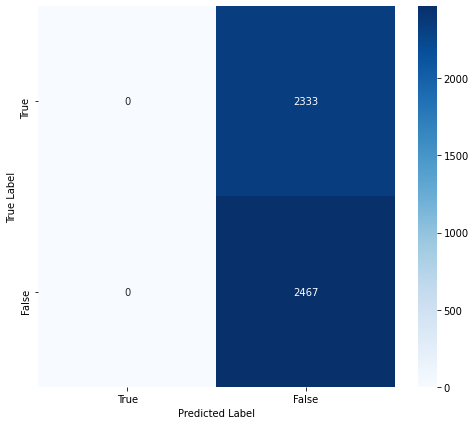

* Average Recall Score: 1.0
* Average Precision Score: 0.5139583333333333
* Average F1 Score: 0.6789596807485895
* Average Accuracy Score: 0.5139583333333333


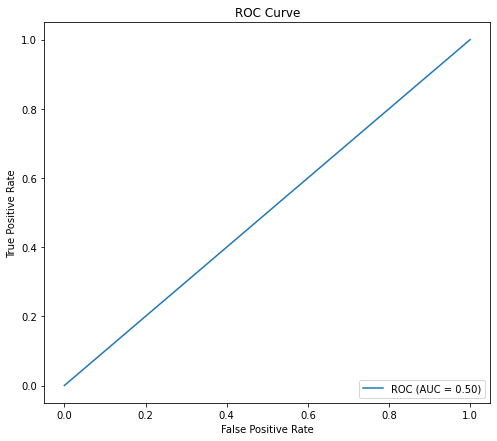

In [17]:
metrics(y_pred, y_true)